# Setup

In [218]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [230]:
# Parameters
model_to_use = 'rf' # "pymer" or "rf"
pct_overlap_cutoff = 0.8

save_plots = False

# Taxonomic & body mass summaries

In [231]:
def shapley_ish_value(aoh_hum_abs, aoh_interest, aoh_other, aoh_joint):
    return (1 / 2) * ((aoh_interest - aoh_hum_abs) + (aoh_joint - aoh_other))

In [232]:
# Read in effective AOH results
if model_to_use == 'pymer':
    aoh_info_fp = '/Users/emiliolr/Desktop/hunting_results/effective_aoh_info_pymer.csv'
elif model_to_use == 'rf':
    aoh_info_fp = '/Users/emiliolr/Desktop/hunting_results/effective_aoh_info_rf.csv'
    
aoh_info = pd.read_csv(aoh_info_fp)

In [233]:
# Read in taxonomic + body mass info for tropical mammal species
tropical_mammals_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/tropical_species/tropical_mammals_taxonomic_info_w_body_mass.csv'
tropical_mammals = pd.read_csv(tropical_mammals_fp)

#  join on tropical mammal info w/effective AOH results
aoh_info = pd.merge(aoh_info, tropical_mammals, how = 'left', left_on = 'species', right_on = 'iucn_id')
aoh_info = aoh_info.drop(columns = ['iucn_id', 'synonyms', 'is_species', 'combine_match_species', 
                                    'combine_bm_match_level'])

In [234]:
# Read in percent overlap w/tropical forest zone info (just current AOH overlap)
aoh_pct_overlap_fp = '/Users/emiliolr/Desktop/hunting_results/tropical_mammals_aoh_overlap.csv'
aoh_pct_overlap = pd.read_csv(aoh_pct_overlap_fp)
aoh_pct_overlap = aoh_pct_overlap.rename(columns = {'aoh_pct_overlap' : 'aoh_pct_overlap_current'})

#  join on percent overlap info w/effective AOH results
aoh_info = pd.merge(aoh_info, aoh_pct_overlap, how = 'left', left_on = 'species', right_on = 'iucn_id')
aoh_info = aoh_info.drop(columns = ['iucn_id'])

#  filter species by percent overlap cutoff
aoh_info = aoh_info[aoh_info['aoh_pct_overlap_current'] >= pct_overlap_cutoff]

In [235]:
# Adding columns to represent AOH percent changes: negative if AOH loss, positive if gain
aoh_info['Hunting (partial)'] = shapley_ish_value(aoh_info['human_absent_aoh_total'],
                                                  aoh_info['human_absent_aoh_w_hunting_total'],
                                                  aoh_info['current_aoh_total'],
                                                  aoh_info['current_aoh_w_hunting_total'])
aoh_info['Hunting (partial)'] = (aoh_info['Hunting (partial)'] / aoh_info['human_absent_aoh_total'])

aoh_info['Land-Cover (partial)'] = shapley_ish_value(aoh_info['human_absent_aoh_total'],
                                                     aoh_info['current_aoh_total'],
                                                     aoh_info['human_absent_aoh_w_hunting_total'],
                                                     aoh_info['current_aoh_w_hunting_total'])
aoh_info['Land-Cover (partial)'] = (aoh_info['Land-Cover (partial)'] / aoh_info['human_absent_aoh_total'])

aoh_info['Combined'] = (aoh_info['current_aoh_w_hunting_total'] / aoh_info['human_absent_aoh_total']) - 1

In [236]:
# Adding a column for body mass category (matching Gallego-Zamorano)
def bm_cats(bm):
    if bm < 0.1:
        return 'very small'
    elif (bm >= 0.1) and (bm < 1):
        return 'small'
    elif (bm >= 1) and (bm < 10):
        return 'medium'
    else:
        return 'large'

aoh_info['body_mass_cat'] = (aoh_info['combine_body_mass'] / 1000).apply(bm_cats)
cat_counts = aoh_info['body_mass_cat'].value_counts()

In [237]:
# Removing a few CRAZY outliers w/huge gains due to contemporary habitat change
aoh_info = aoh_info[aoh_info['Land-Cover (partial)'] < 10]

In [238]:
# Pivoting into a wide format to make plotting easier
value_vars = ['Land-Cover (partial)', 'Hunting (partial)', 'Combined']
id_vars = [c for c in aoh_info.columns if c not in value_vars]
aoh_info = aoh_info.melt(id_vars = id_vars, value_vars = value_vars, var_name = 'aoh_loss_type', 
                         value_name = 'aoh_loss_amt')

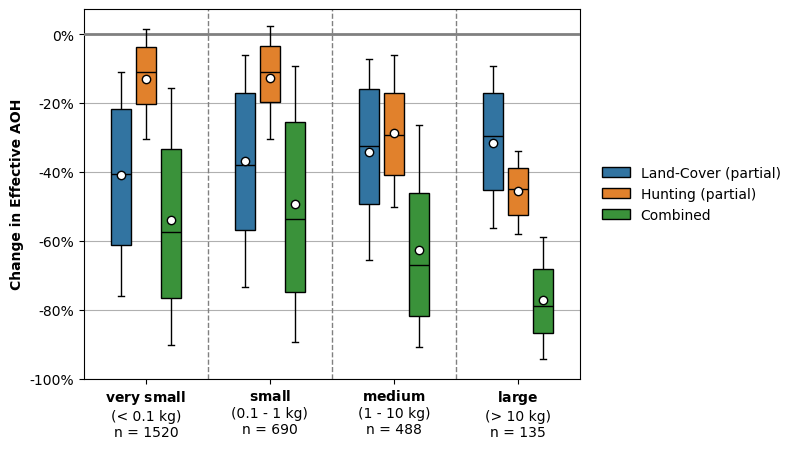

In [239]:
# Plotting effective AOHs by body mass category
bm_cat_order = ['very small', 'small', 'medium', 'large']

sns.boxplot(data = aoh_info, x = 'body_mass_cat', y = 'aoh_loss_amt', hue = 'aoh_loss_type', order = bm_cat_order,
            showfliers = False, whis = (10, 90), width = 0.6, gap = 0.2, capwidths = 0.05, notch = False, linecolor = 'black',
            showmeans = True, meanprops = {'markeredgecolor' : 'black', 'marker' : 'o', 'markerfacecolor' : 'white'},
            zorder = 100)

#  adding line for no AOH change
plt.axhline(0, color = 'grey', linewidth = 2, zorder = 10)

for i in [0.5, 1.5, 2.5]:
    plt.axvline(i, color = 'grey', linewidth = 1, linestyle = '--')

#  labeling axes + title
plt.xlabel(None)
plt.ylabel('Change in Effective AOH', weight = 'bold')

if model_to_use == 'pymer':
    title = f'Linear hurdle\nSpecies with >{int(pct_overlap_cutoff * 100)}% AOH in tropical forests'
else:
    title = f'Random forest hurdle\nSpecies with >{int(pct_overlap_cutoff * 100)}% AOH in tropical forests'
# plt.title(title, weight = 'bold')

#  fiddling w/tick formatting
if model_to_use == 'pymer':
    yticks = np.arange(-1, 0.2, 0.2)
else:
    yticks = np.arange(-1, 0.2, 0.2)
ytick_labels = [f'{round(float(i))}%' for i in yticks * 100]
plt.yticks(ticks = yticks, labels = ytick_labels)

xtick_labels = [r'$\bf{very\ small}$' + f'\n(< 0.1 kg)\nn = {cat_counts.loc["very small"]}', 
                r'$\bf{small}$' + f'\n(0.1 - 1 kg)\nn = {cat_counts.loc["small"]}', 
                r'$\bf{medium}$' + f'\n(1 - 10 kg)\nn = {cat_counts.loc["medium"]}',
                r'$\bf{large}$' + f'\n(> 10 kg)\nn = {cat_counts.loc["large"]}']
plt.xticks(ticks = [0, 1, 2, 3], labels = xtick_labels)

#  fixing the legend
plt.legend(loc = 'center right', bbox_to_anchor = (1.43, 0.5), frameon = False)

#  adding major gridlines
plt.grid(visible = True, which = 'major', axis = 'y')

#  optionally saving plot
if save_plots:
    plt.savefig(f'/Users/emiliolr/Desktop/{model_to_use}_aoh_diff_cutoff={pct_overlap_cutoff}.png', 
                bbox_inches = 'tight', dpi = 400)

plt.show()

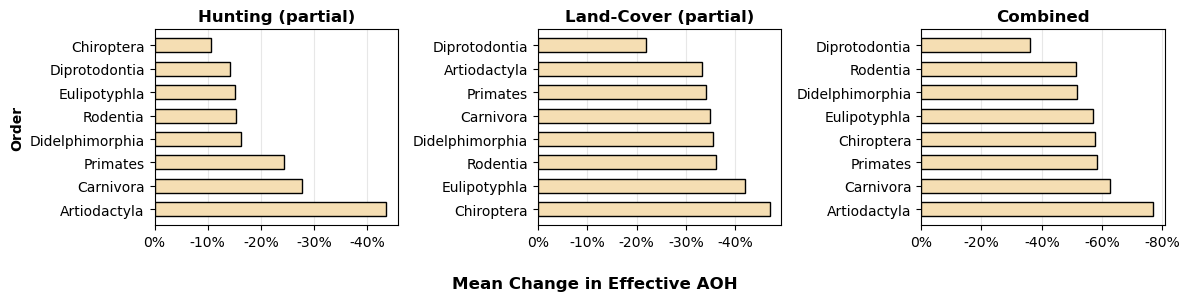

In [240]:
# Taxonomic summaries of change in effective AOH
tax_level = 'order'
tax_n_thresh = 50

fig, axs = plt.subplots(1, 3, figsize = (12, 3))

for i, loss_type in enumerate(['Hunting (partial)', 'Land-Cover (partial)', 'Combined']):
    #  filtering out underrepresented tax levels
    tax_to_keep = aoh_info[tax_level].value_counts() / 3
    tax_to_keep = tax_to_keep[tax_to_keep > tax_n_thresh].index.to_list()
    
    aoh_info_grouped = aoh_info[aoh_info[tax_level].isin(tax_to_keep)]
    
    #  grouping + extracting mean effect
    aoh_info_grouped = aoh_info_grouped[aoh_info_grouped['aoh_loss_type'] == loss_type].groupby([tax_level])
    
    mean_aoh_effect = aoh_info_grouped['aoh_loss_amt'].mean().sort_values()
    mean_aoh_effect = mean_aoh_effect.to_frame().reset_index()
    mean_aoh_effect[tax_level] = mean_aoh_effect[tax_level].str.title()
    
    #  plotting in barplot format
    axs[i].barh(mean_aoh_effect[tax_level], mean_aoh_effect['aoh_loss_amt'] * -1, color = 'wheat', 
                edgecolor = 'black', height = 0.6, zorder = 10)
    axs[i].grid(visible = True, which = 'major', axis = 'x', alpha = 0.3, zorder = 0)
    
    if i == 0:
        axs[i].set_ylabel(str(tax_level).title(), weight = 'bold')
    axs[i].set_title(loss_type, weight = 'bold')
    
    xticks = axs[i].get_xticks()
    xlim = axs[i].get_xlim()
    axs[i].set_xticks(xticks, [f'{"-" if x > 0 else ("+" if x < 0 else "")}{abs(int(x * 100))}%' for x in xticks])
    axs[i].set_xlim(xlim)

fig.supxlabel('Mean Change in Effective AOH', weight = 'bold')
fig.tight_layout()

if save_plots:
    plt.savefig(f'/Users/emiliolr/Desktop/{model_to_use}_tax_breakdown_partial_w_joint.png', 
                bbox_inches = 'tight', dpi = 400)

# Proof of concept for $\Delta$AOH

In [471]:
import rioxarray as rxr

In [477]:
# CURRENT AOH
ex_cur_aoh_fp = "/Users/emiliolr/Desktop/phd-exploratory-work/data/elephants/7140_RESIDENT.tif"
ex_cur_aoh = rxr.open_rasterio(ex_cur_aoh_fp)

# HUMAN-ABSENT AOH
ex_prev_aoh_fp = "/Users/emiliolr/Desktop/phd-exploratory-work/data/elephants/human_absent/7140_RESIDENT.tif"
ex_prev_aoh = rxr.open_rasterio(ex_prev_aoh_fp)

# HUNTING PRESSURE MAP
ex_hp_fp = "/Users/emiliolr/Desktop/hunting_testing/current/7140_hunting_pred_pymer.tif"
ex_hp = rxr.open_rasterio(ex_hp_fp)

In [478]:
# TOTAL HUMAN-ABSENT AOH
prev_aoh_tot = float(ex_prev_aoh.sum())

# COMBINED: HP + HL
ex_hp = ex_hp.rio.reproject_match(ex_cur_aoh)

no_pred_mask = ((ex_cur_aoh != 0) & (xr.ufuncs.isnan(ex_hp)))
ex_hp = ex_hp.where(~no_pred_mask, other = 1)

effective_aoh = ex_cur_aoh * ex_hp

In [479]:
# FINAL PRODUCT
effective_aoh = effective_aoh.rio.reproject_match(ex_prev_aoh).fillna(0)
delta_aoh_tot = effective_aoh - ex_prev_aoh
delta_aoh_tot_pct = (delta_aoh_tot.where(ex_prev_aoh != 0) / ex_prev_aoh) # | (ex_cur_aoh != 0)

In [490]:
float(effective_aoh.min()) 

False

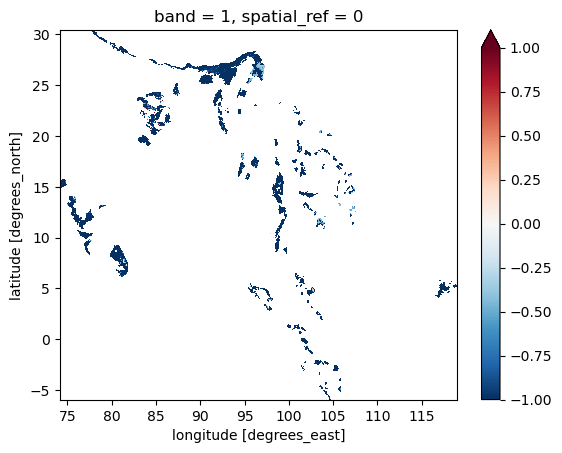

In [482]:
delta_aoh_tot_pct.squeeze().plot.pcolormesh(vmin = -1, vmax = 1, center = 0, cmap = 'RdBu_r');

In [483]:
# TEMPLATE INTERACTION
template_raster_cell_area = rxr.open_rasterio("/Users/emiliolr/Desktop/template_raster_cell_area.tif")
delta_aoh_tot_pct = delta_aoh_tot_pct.rio.reproject_match(template_raster_cell_area)
delta_aoh_tot_pct_per_km2 = delta_aoh_tot_pct / template_raster_cell_area

In [486]:
delta_aoh_tot_pct_per_km2.min()

<xarray.DataArray ()> Size: 4B
array(-0.33794916, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0

In [492]:
template_raster_cell_area.max()

<xarray.DataArray ()> Size: 4B
array(3.4191866, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0